In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
import statsmodels.api as sm
import plotly.graph_objects as go
import numpy as np
from pandas_datareader import data as wb
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

/Users/danvaldes/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Pandas display options to supress scientifc notation and show all columns and all rows if necessary. Puts a lot of strain of processor

In [2]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [3]:
nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
amex = pd.read_csv(os.path.join('Resources', 'amex.csv'))

frames = [nyse, nasdaq, amex]
tickers = pd.concat(frames).sort_values(by='Ticker')

data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

In [4]:
df = df[df['Market Cap'].notna()];

In [5]:
df['Market Cap Size'] = ['Large Cap' if x > 10000000000 else 'Mid Cap' if x > 2000000000 else 'Small Cap' for x in df['Market Cap']]

Note: In *__data_2018__* we had 4392 observations. When we merged with our *__tickers__* dataframe which had 8000+ tickers and company names from exchanges we lost 150 observations. These can be retrieved with 
``` 
data_2018[~data_2018.Ticker.isin(tickers['Ticker'])]
```
Here the **~** symbol essentially means NOT IN when we filter.\
Lastly, a dataframe with just indicators we can manipulate. We can filter out some of the columns containing information we don't need then pass this as a filter to our working dataframe with ```df[x['Indicator']]```

We can create a dataframe that counts the null values across each column to see what we can begin to drop. We can choose some threshold for amount of null values that once met causes us to drop the column. If we choose 500, we trim out about 30 columns. 

In [28]:
null_count = pd.DataFrame(df.isna().sum().sort_values(ascending=False))

In [30]:
null_count;

In [8]:
null_count[null_count[0] >= 500];

In [9]:
to_drop = null_count[null_count[0] >= 500].index

In [10]:
df = df.drop(columns=to_drop)

In [11]:
df.head()

,Ticker,Company Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class,Market Cap Size
0,A,Agilent Technologies,4914000000.00,0.10,2227000000.00,2687000000.00,385000000.00,1374000000.00,1759000000.00,928000000.00,...,0.11,0.01,-0.05,-0.11,0.14,0.12,Healthcare,30.98,1,Large Cap
1,AA,Alcoa Corp,13403000000.00,0.15,10081000000.00,3322000000.00,31000000.00,248000000.00,1603000000.00,1719000000.00,...,0.25,-0.08,0.23,0.28,-0.03,-0.11,Basic Materials,-18.03,0,Mid Cap
2,AAL,American Airlines Gp,44541000000.00,0.04,20400000000.00,24141000000.00,0.00,13771000000.00,21485000000.00,2656000000.00,...,0.12,0.15,0.77,0.36,0.00,0.03,Industrials,-10.60,0,Large Cap
3,AAMC,Altisource Asset,15926000.00,-0.12,0.00,15926000.00,0.00,22534000.00,22534000.00,-6608000.00,...,0.00,-0.18,-0.03,0.00,0.00,-0.12,Financial Services,-58.85,0,Small Cap
4,AAME,Atlantic Amer Cp,185553000.00,0.02,132650000.00,52903000.00,0.00,39042000.00,51837000.00,1066000.00,...,0.00,0.00,-0.09,0.00,0.00,-0.10,Financial Services,-20.25,0,Small Cap


If we count the null values across rows, we see that some companies are missing info on 150+ columns. We set the threshold to be 120, meaning rows with less than 120 populated columns are dropped.

In [12]:
row_null_count = pd.DataFrame(df.isnull().sum(axis = 1).sort_values(ascending=False))

In [13]:
row_null_count.head(5)

,0
1153,106
1819,104
220,103
1219,101
3862,98


In [14]:
df = df.dropna(thresh=120)

Finally we fill null values with the means across cap size

In [16]:
small_caps = df[df['Market Cap Size'] == 'Small Cap']
mid_caps = df[df['Market Cap Size'] == 'Mid Cap']
large_caps = df[df['Market Cap Size'] == 'Large Cap']

In [17]:
small_caps = df[df['Market Cap Size'] == 'Small Cap'].fillna(small_caps.mean())
mid_caps = df[df['Market Cap Size'] == 'Mid Cap'].fillna(mid_caps.mean())
large_caps = df[df['Market Cap Size'] == 'Large Cap'].fillna(large_caps.mean())

In [22]:
caps = [small_caps, mid_caps, large_caps]

market = pd.concat(caps)

market;

In [24]:
indicators = pd.DataFrame({
   'Indicator': market.columns.tolist()
})

filt = indicators[indicators['Indicator'].str.contains('Growth|growth|Margin|ratio|Ratio|Turnover|per|/| / | to |Per|return|To|days|Days') == False]

cond = filt['Indicator'].to_list()

In [44]:
# market.to_csv(os.path.join('cleaned_data.csv'))

## CONDITIONAL FILTERING

In [ ]:
tickers[tickers['Ticker'].str.startswith('BA') == True];

In [ ]:
tickers[tickers['Company Name'].str.contains('ETF') == True];

In [ ]:
df[df['Company Name'].str.contains('ETF') == True];

In [ ]:
df[df['Ticker'].str.startswith('BA') == True];

In [ ]:
df[df['Revenue Growth'] > 10].sort_values(by='Revenue', ascending=False).head()

# ITERATORS

Sector breakdown across Market Cap Sizes

In [ ]:
count = pd.DataFrame(df.groupby(['Market Cap Size'])['Sector'].value_counts());

count_gen = count.groupby(['Market Cap Size']).__iter__()

In [ ]:
count_group_id, count_grouped_data = count_gen.__next__()
print(count_group_id) 
count_grouped_data

Iterate across Market Caps and Sectors

In [ ]:
mcap_gen = df.groupby(['Market Cap Size']).__iter__()
sector_gen = df.groupby(['Sector']).__iter__()

In [ ]:
market_group_id, market_grouped_data = mcap_gen.__next__()
print(market_group_id) 
market_grouped_data;

In [ ]:
sector_group_id, sector_grouped_data = sector_gen.__next__()
print(sector_group_id)
sector_grouped_data;

In [ ]:
scap_gen = small_caps.groupby(['Sector']).__iter__()

In [ ]:
scap_group_id, scap_grouped_data = scap_gen.__next__()
print(scap_group_id) 
scap_grouped_data.sort_values(by='Revenue Growth', ascending=False)

In [ ]:
assets = scap_grouped_data['Ticker'].to_list()

pf_data = pd.DataFrame()

for a in assets:
    pf_data[a] = wb.DataReader(a, data_source = 'yahoo', start = '2018-1-1')['Adj Close']


In [ ]:
mcap_gen = mid_caps.groupby(['Sector']).__iter__()

In [ ]:
mcap_group_id, mcap_grouped_data = mcap_gen.__next__()
print(mcap_group_id) 
mcap_grouped_data.sort_values(by='Revenue Growth', ascending=False)

In [ ]:
assets = mcap_grouped_data['Ticker'].to_list()

pf_data = pd.DataFrame()

for a in assets:
    pf_data[a] = wb.DataReader(a, data_source = 'yahoo', start = '2018-1-1')['Adj Close']


In [ ]:
lcap_gen = large_caps.groupby(['Sector']).__iter__()

In [ ]:
lcap_group_id, lcap_grouped_data = lcap_gen.__next__()
print(lcap_group_id) 
lcap_grouped_data.sort_values(by='Revenue Growth', ascending=False)

In [ ]:
assets = lcap_grouped_data['Ticker'].to_list()

pf_data = pd.DataFrame()

for a in assets:
    pf_data[a] = wb.DataReader(a, data_source = 'yahoo', start = '2018-1-1')['Adj Close']

(pf_data / pf_data.iloc[0] * 100).iplot(asFigure=True)

## GRAPHS & VISUALIZATIONS

Count of Companies by Sector

In [ ]:
plt.figure(figsize=(18,8))
sns.countplot(x='Sector', data = df, palette='viridis', order=df['Sector'].value_counts().index).set_xticklabels(labels = df['Sector'].value_counts().index, fontdict={'fontsize': 12},rotation=30)
plt.tight_layout()
plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

Revenues by Sector

In [ ]:
sector_rev = pd.DataFrame(df.groupby(['Sector']).mean()['Revenue']).reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Revenues by Sector')
sns.barplot(x = sector_rev['Sector'], y = sector_rev['Revenue'], palette='viridis',).set_xticklabels(labels = sector_rev['Sector'], fontdict={'fontsize': 12}, rotation=30)
plt.tight_layout();
plt.savefig(os.path.join('Figures','SectorRev.png'))

Count of Companies across Market Cap Sizes

In [ ]:
plt.figure(figsize=(18,8))
sns.countplot(x='Market Cap Size', data = df, palette='viridis', order=df['Market Cap Size'].value_counts().index).set_xticklabels(labels = df['Market Cap Size'].value_counts().index, fontdict={'fontsize': 12},rotation=30)
plt.tight_layout()
plt.ylabel('Company Count')
plt.savefig(os.path.join('Figures','MarketCapBreakdown.png'))

In [ ]:
bars = []
sectors = df['Sector'].unique()
caps=['Small Cap', 'Mid Cap', 'Large Cap']
for sector in sectors:
    bars.append(go.Bar(name=sector, x=caps, y=np.array(df[df['Sector'] == sector]['Market Cap Size'].value_counts())))

plt.figure(figsize=(30,12))
fig = go.Figure(data=bars)
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

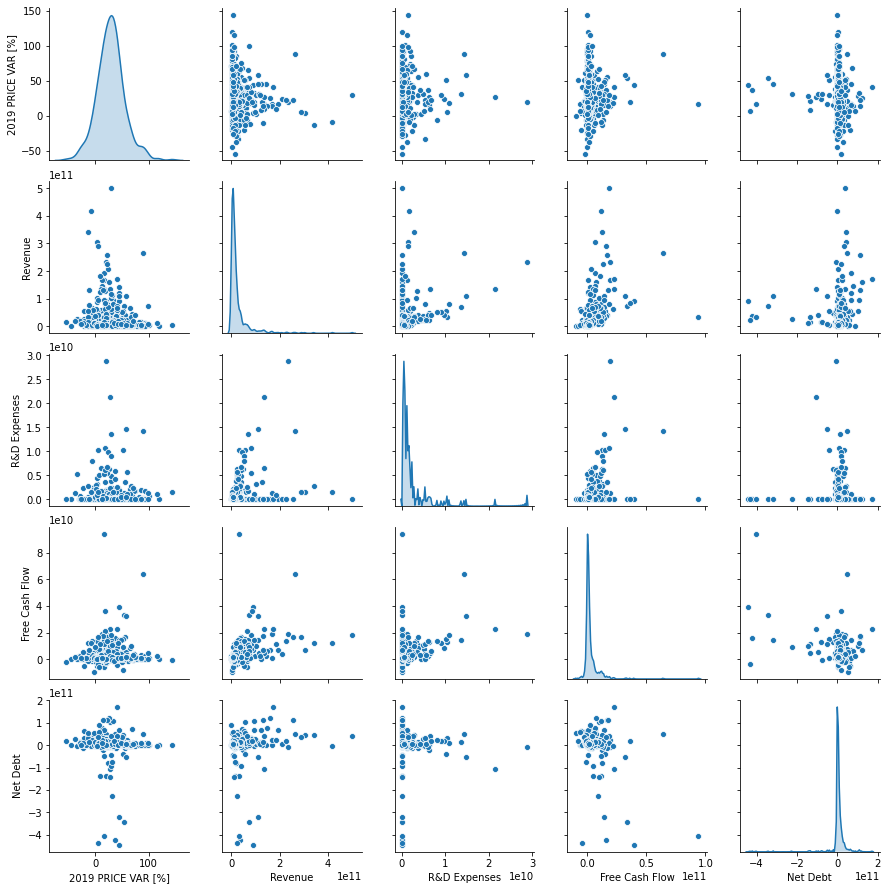

In [36]:
sns.pairplot(large_caps[['2019 PRICE VAR [%]', 'Revenue', 'R&D Expenses', 'Sector','Free Cash Flow','Net Debt']], diag_kind="kde")

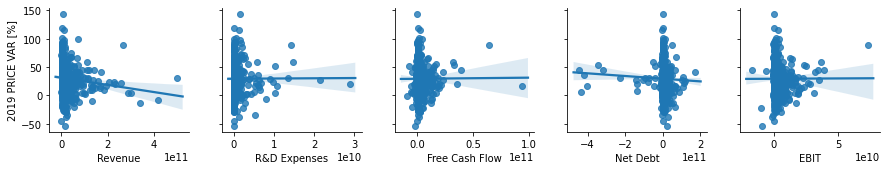

In [35]:
sns.pairplot(large_caps, x_vars=['Revenue', 'R&D Expenses', 'Free Cash Flow','Net Debt','EBIT'], y_vars=['2019 PRICE VAR [%]'], kind='reg')

Text(0.5, 1.0, 'Correlations Among Corporate Financial Indicators')

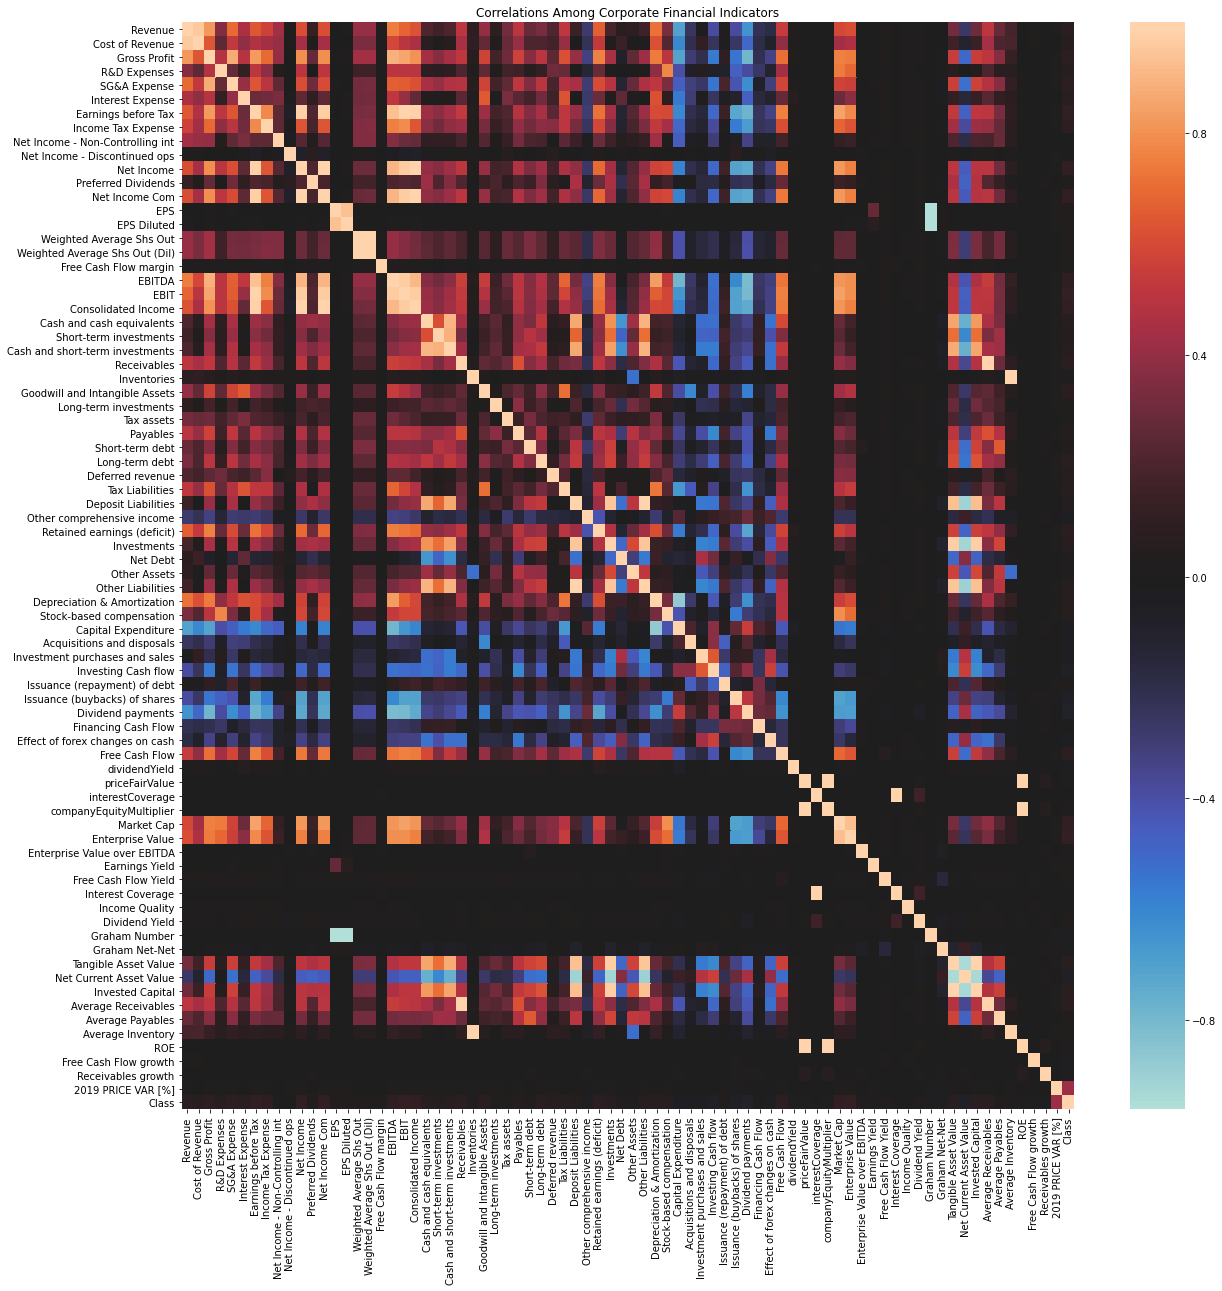

In [34]:
corrs = market[cond].corr()

plt.figure(figsize=(20,20))
g = sns.heatmap(corrs, center=0)
plt.title('Correlations Among Corporate Financial Indicators')
# plt.savefig(os.path.join('Figures','correlations.png'))

In [ ]:
px.scatter(large_caps, x='Free Cash Flow', y='2019 PRICE VAR [%]', hover_data=['Company Name','Ticker','Market Cap','Sector'])

## Linear Regression Analysis

In [ ]:
y = market["2019 PRICE VAR [%]"]

X = sm.add_constant(market[cond].iloc[:,0:-2])

In [ ]:
reg = sm.OLS(y, X).fit()

reg.summary();